## Travelling salesman

Code to try and find a solution to the travelling salesman problem on the globe using object-oriented simulated annealing

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import csv
import smopy

In [10]:
#smopy tile server and basic options
smopy.TILE_SERVER = "http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}@2x.png"
smopy.TILE_SIZE = 512

In [14]:
# generate world map ((lat_min, long_min, lat_max, long_max) , z=zoom_level)
# play with the values here to view different areas -- note that the zoom level may be changed to something more appropriate
worldmap = smopy.Map((0, -120, 65, 120), z=2)

#greater dublin
irishmap = smopy.Map((51.5, -9., 55, -5.6), z=8)


Lowered zoom level to keep map size reasonable. (z = 7)


KeyboardInterrupt: 

In [57]:
class SalesmanAnneal:
    '''Solves the TSM problem using a simulated annealing approach'''
    
    def __init__(self, lats, lons, cities, basemap,stopping_itt, T,alpha):
        '''initialise the solver, loads city coordinates/names from arguments '''
        self.lats = lats
        self.lons = lons
        self.cities=cities
        self.N= len( cities )
        self.basemap=basemap
        self.itt=1
        self.itt=1
        self.stopping_itt=stopping_itt
        self.T = T 
        self.alpha=alpha

        self.itterlist=[]
        self.lenght=[]
        
        self.lenght1=[]
        self.lst=[(i)%self.N for i in range(0,2*self.N)]
        
        self.initial_route=(np.random.permutation(np.arange(self.N)))
        self.bestroute = np.copy(self.initial_route)
        
        self.cur_fitness= self.fitness(np.copy(self.bestroute))
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        
        
    def fitness(self, candidate):
        '''returns the "fitness", i.e. total RETURN path length.'''
        fit=0
        for i in range(0,len(candidate)): 
            fit+=self.gcd(self.lats[ candidate[i] ], self.lons[ candidate[i] ], self.lats[ candidate[(i+1)%self.N] ], self.lons[candidate[(i+1)%self.N]])
        self.lenght.append(fit)
        return fit
    
        
        # The length of the shortest path between a and b
    def gcd(self,alat, alon, blat, blon):
        lat1 = np.radians(alat)
        lat2 = np.radians(blat)
        lon1 = np.radians(alon)
        lon2 = np.radians(blon)

        dlon = lon2 - lon1 
        dlat = lat2 - lat1 

        hav = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2))**2 
        c = 2 * np.arctan2( np.sqrt(hav), np.sqrt(1-hav) ) 
        return 6371* c 


    # A function that returns "num" points on the shortest path between a and b
    def gcd_path(self,alat, alon, blat, blon, num):
        lat1 = np.radians(alat)
        lat2 = np.radians(blat)
        lon1 = np.radians(alon)
        lon2 = np.radians(blon)

        d=self.gcd(alat, alon, blat, blon)
        f= np.linspace(0, 1, num)

        delta = d / 6371
        alpha = np.sin((1-f)*delta) / np.sin(delta)
        beta = np.sin(f*delta) / np.sin(delta)

        x = alpha * np.cos(lat1) * np.cos(lon1) + beta * np.cos(lat2) * np.cos(lon2)
        y = alpha * np.cos(lat1) * np.sin(lon1) + beta * np.cos(lat2) * np.sin(lon2)
        z = alpha * np.sin(lat1) + beta * np.sin(lat2)

        newlats = (np.arctan2(z, np.sqrt(x**2 + y**2)))
        newlons = (np.arctan2(y, x))
        return np.degrees(newlats), (np.degrees(newlons) +540)%360 -180   

    
    
    def accept(self, candidate):
        
        candidate_fitness = np.copy(self.fitness( candidate ))
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.currentgrid = candidate
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.bestroute = candidate
                self.itterlist.append(self.itt)
                self.lenght1.append(np.copy(self.cur_fitness))

        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness - self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.currentgrid = candidate
                

            
            
    
    def print_grid(self, path):
        '''Outputs a pretty map showing a particular route'''
        px, py = [], []
        p1x, p1y = [], []
        plot1, ax = plt.subplots(figsize=(20, 17.5))

        for i in range(len(self.lats)):
            plotx, ploty = self.basemap.to_pixels(self.lats[i], self.lons[i])
            px.append(plotx)
            py.append(ploty)
                    
        for i in range(0,len(path)):
            path_lat, path_lon = self.gcd_path(self.lats[ path[i] ], self.lons[ path[i] ], self.lats[ path[(i+1)%self.N] ], self.lons[path[(i+1)%self.N]],100)
            plotx, ploty = self.basemap.to_pixels(path_lat, path_lon)
            p1x.append(plotx)
            p1y.append(ploty)
            
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        ax.set_xlim(0, self.basemap.w)
        ax.set_ylim(self.basemap.h, 0)
        ax.axis('off')
        plt.tight_layout()
        ax.imshow(self.basemap.img)

        #plot points for each city
        ax.plot(px, py, 'ro')

        #plot great circular path
        ax.plot(p1x, p1y, 'go', ms=0.8, alpha=0.8)

        #include labels
        #""[ax.annotate(self.cities[i], xy=(px[i], py[i]), xytext=(px[i]+36, py[i]+15), color='k', size=10) for i in range(0, len(self.cities))]
        plt.show(plot1)
        
    def print_inf(self):
        print(self.bestroute-self.initial_route)
        
    def anneal(self):
        '''simulated annealing to find solution'''

        while self.itt < self.stopping_itt:
            
            # generate a new candidate solution
            candidate = np.copy(self.bestroute)

            # pick two random elements and swap path
            rands = np.random.choice(range(0,self.N),2, replace=False)

            if rands[0]<rands[1]:
                indexlst=[i%self.N for i in range(rands[0], rands[1]+1)]
            else:
                indexlst=[i%self.N for i in range(rands[0], self.N+rands[1]+1)]

            rindexlst=np.copy(indexlst[::-1])
            for i,j in zip(indexlst,rindexlst):
                candidate[j]=np.copy(self.bestroute[i])

            # accept the new candidate?
            self.accept(candidate)            
            
            # update conditions
            self.T *= self.alpha
            self.itt+=1
            
            

In [58]:
# Lists which we want to fill
countrynames, citynames, lats, longs, pops=[], [], [],[],[]
irish_countrys, irish_cities,ilats,ilongs=[],[],[],[]
max_countrys,max_countrys,mlats,mlongs=[],[],[],[]
tcits,tlats,tlons,tpop=[],[],[],[]

with open('/Users/macuser/Hw_powers/Hw_3/simplemaps-worldcities-basic(1).csv', encoding="utf8") as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')

    #skip the first line, which contains the legend
    next(readCSV)
    
    #add elements row-wise
    for row in readCSV:
        city = row[1]
        lat = float(row[2])
        long = float(row[3])
        pop= float(row[4])
        country = row[5]
    
        countrynames.append(country)
        citynames.append(city)
        lats.append(lat)
        longs.append(long) 
        pops.append(pop)
        
        if row[5] == 'Ireland':
            irish_cities.append(city)
            ilats.append(lat)
            ilongs.append(long) 
            


In [59]:
spops=np.copy(pops).tolist()
spops.sort(reverse=True)
indarr=[]

for p in (spops):
    indarr.append(pops.index(p))

for i in range(0,30):
    tlats.append(lats[indarr[i]])
    tlons.append(longs[indarr[i]])
    tcits.append(citynames[indarr[i]])
    tpop.append(pops[indarr[i]])

In [60]:


num_cities=30
rands = np.random.choice(range(0,len(longs)),num_cities, replace=False)
rlats=[lats[i] for i in rands]
rlons=[longs[i] for i in rands]
rcit=[citynames[i] for i in rands]
rcon=[countrynames[i] for i in rands]

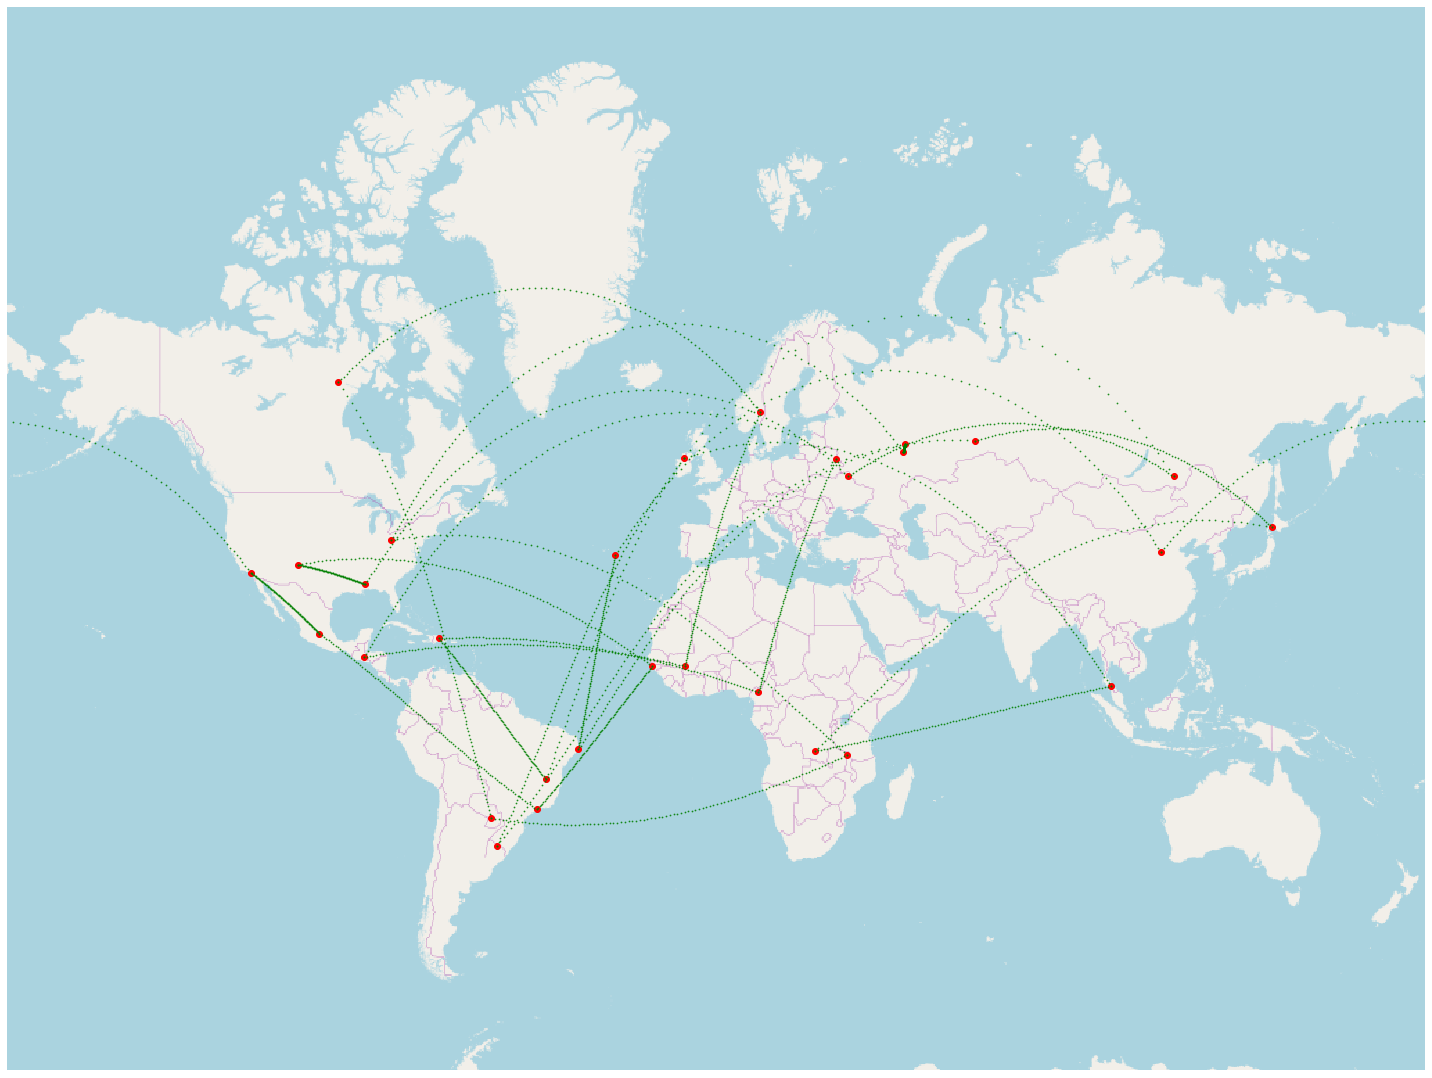

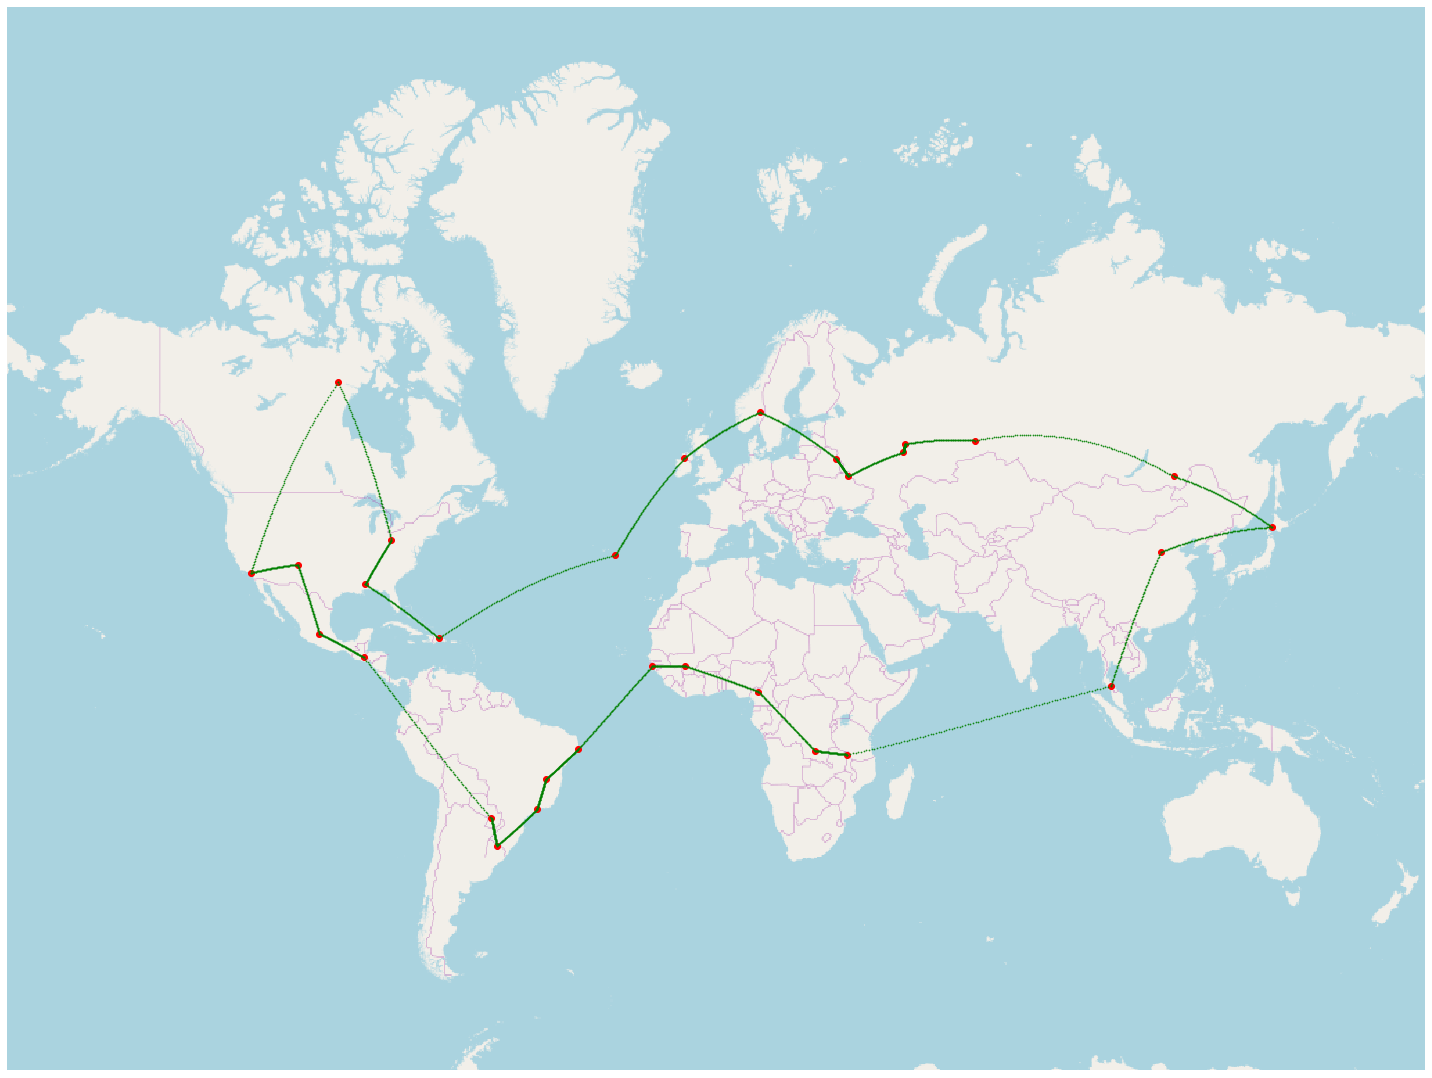

In [88]:
T=1E10
random_cities=SalesmanAnneal(lats=rlats, lons=rlons, cities=rcit, basemap=worldmap, stopping_itt=5000,T=T,alpha=.97)
random_cities.anneal()
random_cities.print_grid(random_cities.initial_route)
random_cities.print_grid(random_cities.bestroute)

Initial temp= 10000000000.0 
Final temp= 2.127951970682161e-53
['Xinzhou', 'Hamar', 'Phatthalung', 'Donegal', 'Kanash', 'Shilka', 'Chiquimula', 'Pasadena', 'Chitipa', 'Baker Lake', 'Mansfield', 'Kumbo', 'Celaya', 'Janauba', 'Bamako', 'Otaru', 'Kamina', 'Los Alamos', 'Taubate', 'Tyumen', 'Arroyos y Esteros', 'Yoshkar Ola', 'Orsha', 'Salcedo', 'Ziguinchor', 'Laurel', 'Ponta Delgada', 'Shostka', 'Cabo de Santo Agostinho', 'Tranqueras']


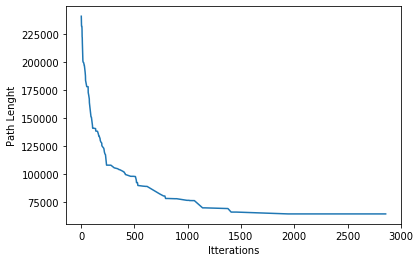

In [95]:
plt.plot(random_cities.itterlist,random_cities.lenght1)
plt.xlabel('Itterations')
plt.ylabel('Path Lenght')
print('Initial temp=',T,'\nFinal temp=',random_cities.T*random_cities.itterlist[-1])
print(rcit)

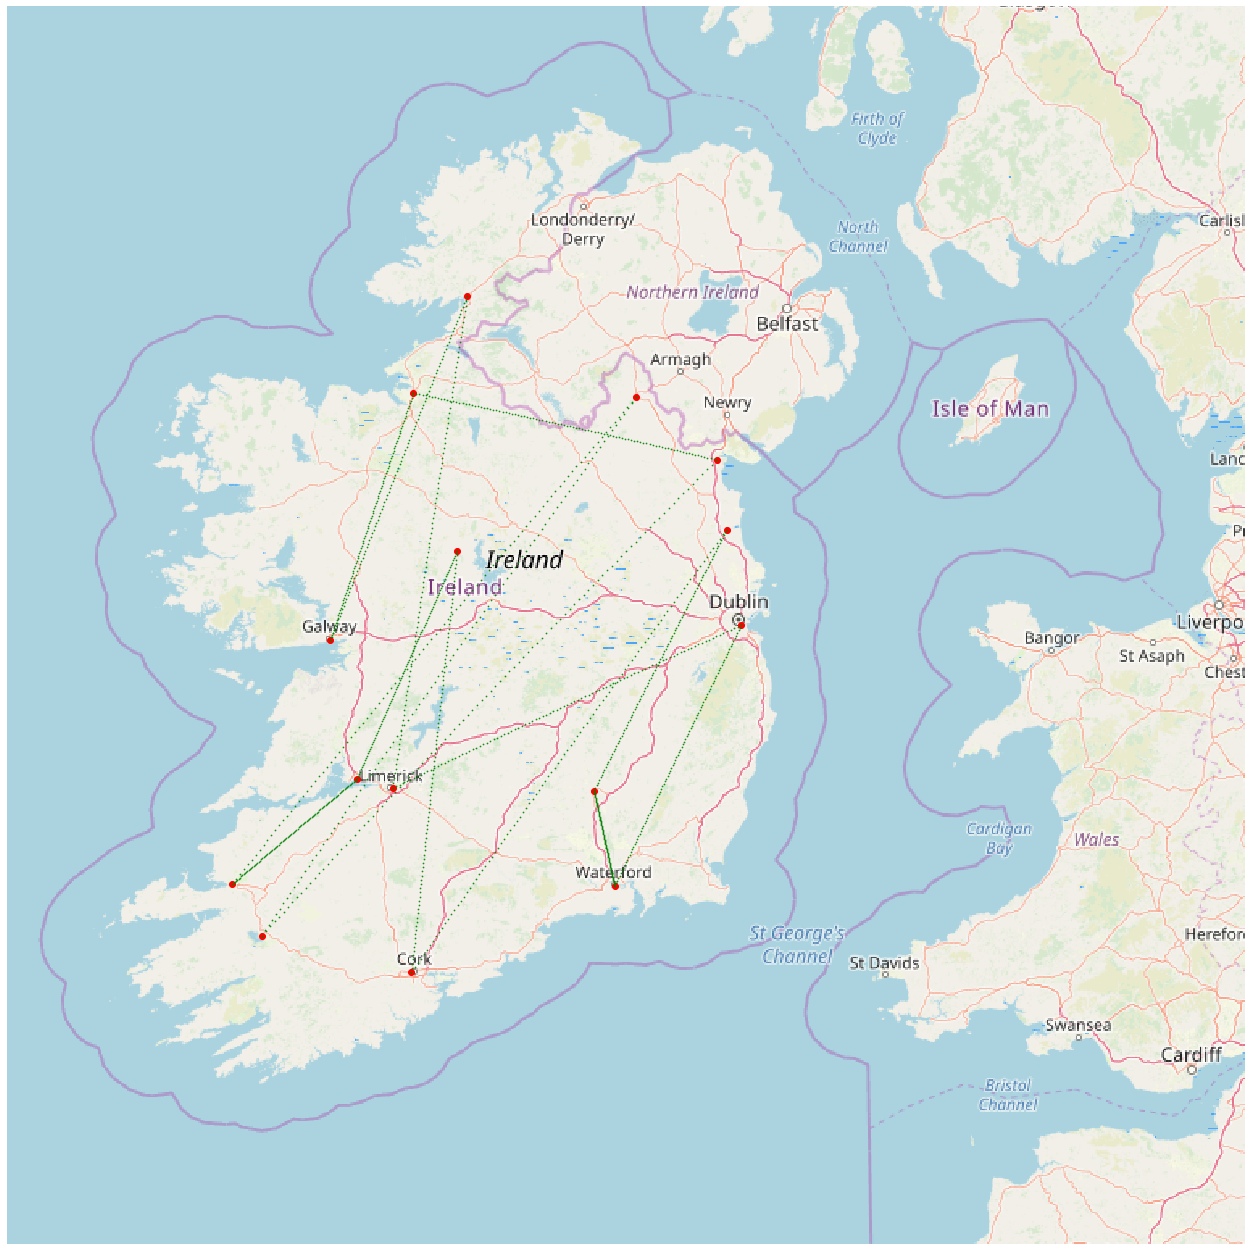

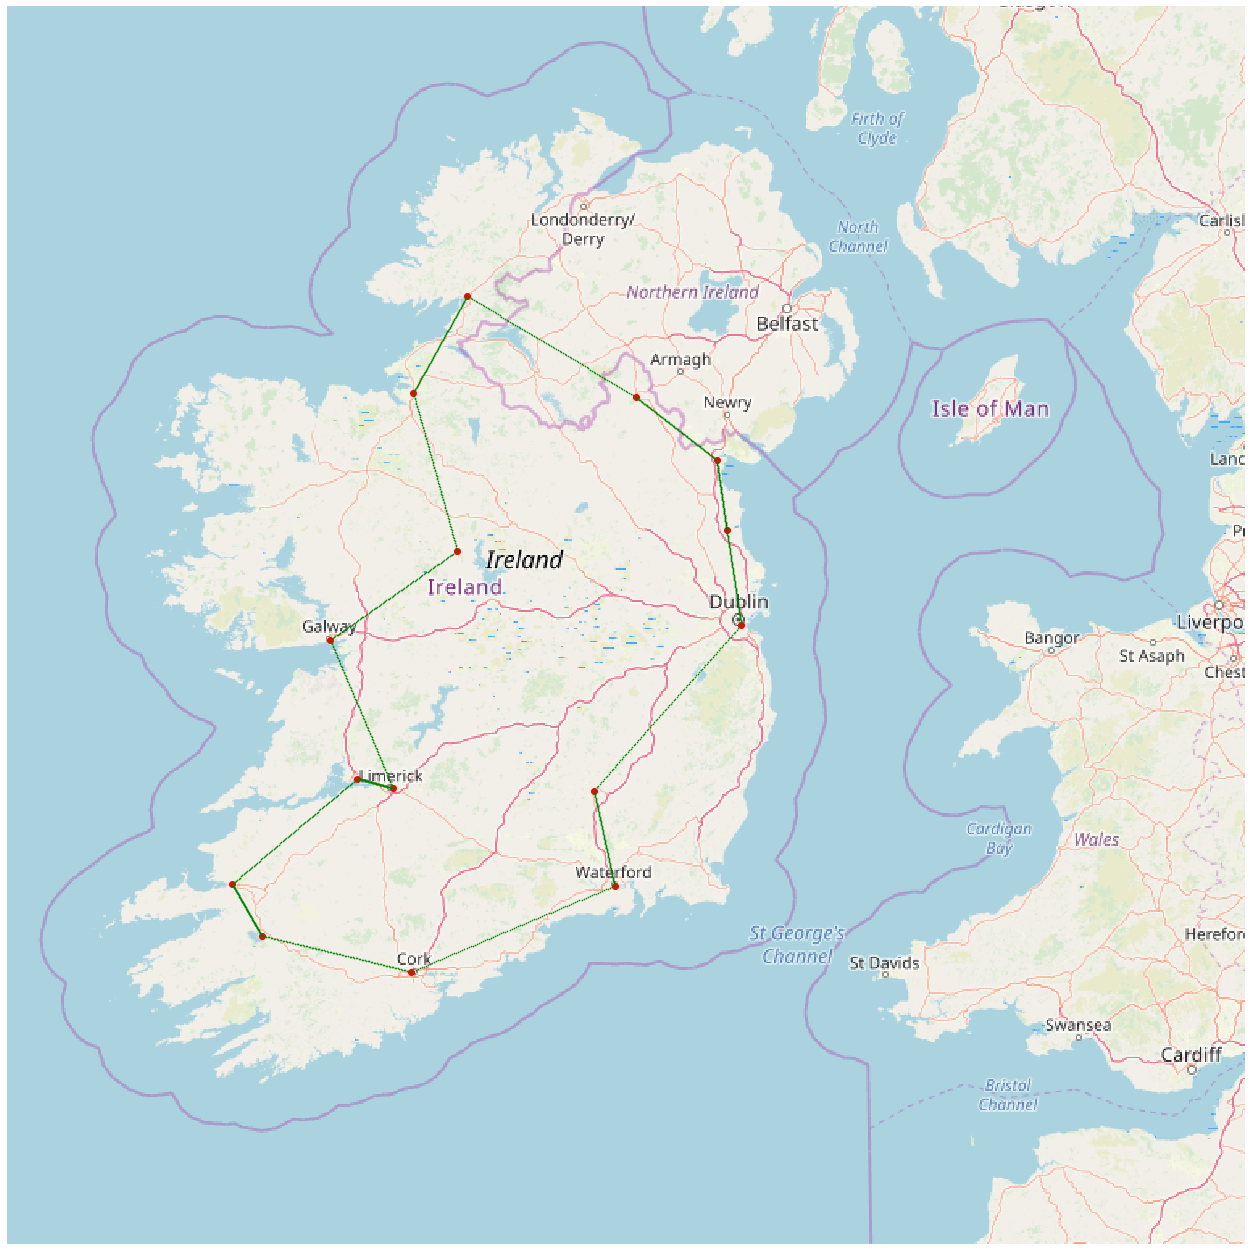

In [102]:
T=1E10
irish=SalesmanAnneal(lats=ilats, lons=ilongs, cities=irish_cities, basemap=irishmap, stopping_itt=2000,T=T,alpha=.97)
irish.anneal()
irish.print_grid(irish.initial_route)
irish.print_grid(irish.bestroute)

Initial temp= 10000000000.0 
Final temp= 1.4816740453665154e-54


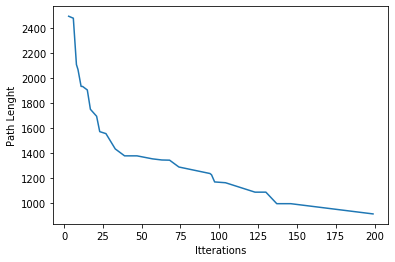

In [103]:
plt.plot(irish.itterlist,irish.lenght1)
plt.xlabel('Itterations')
plt.ylabel('Path Lenght')
print('Initial temp=',T,'\nFinal temp=',random_cities.T*irish.itterlist[-1])


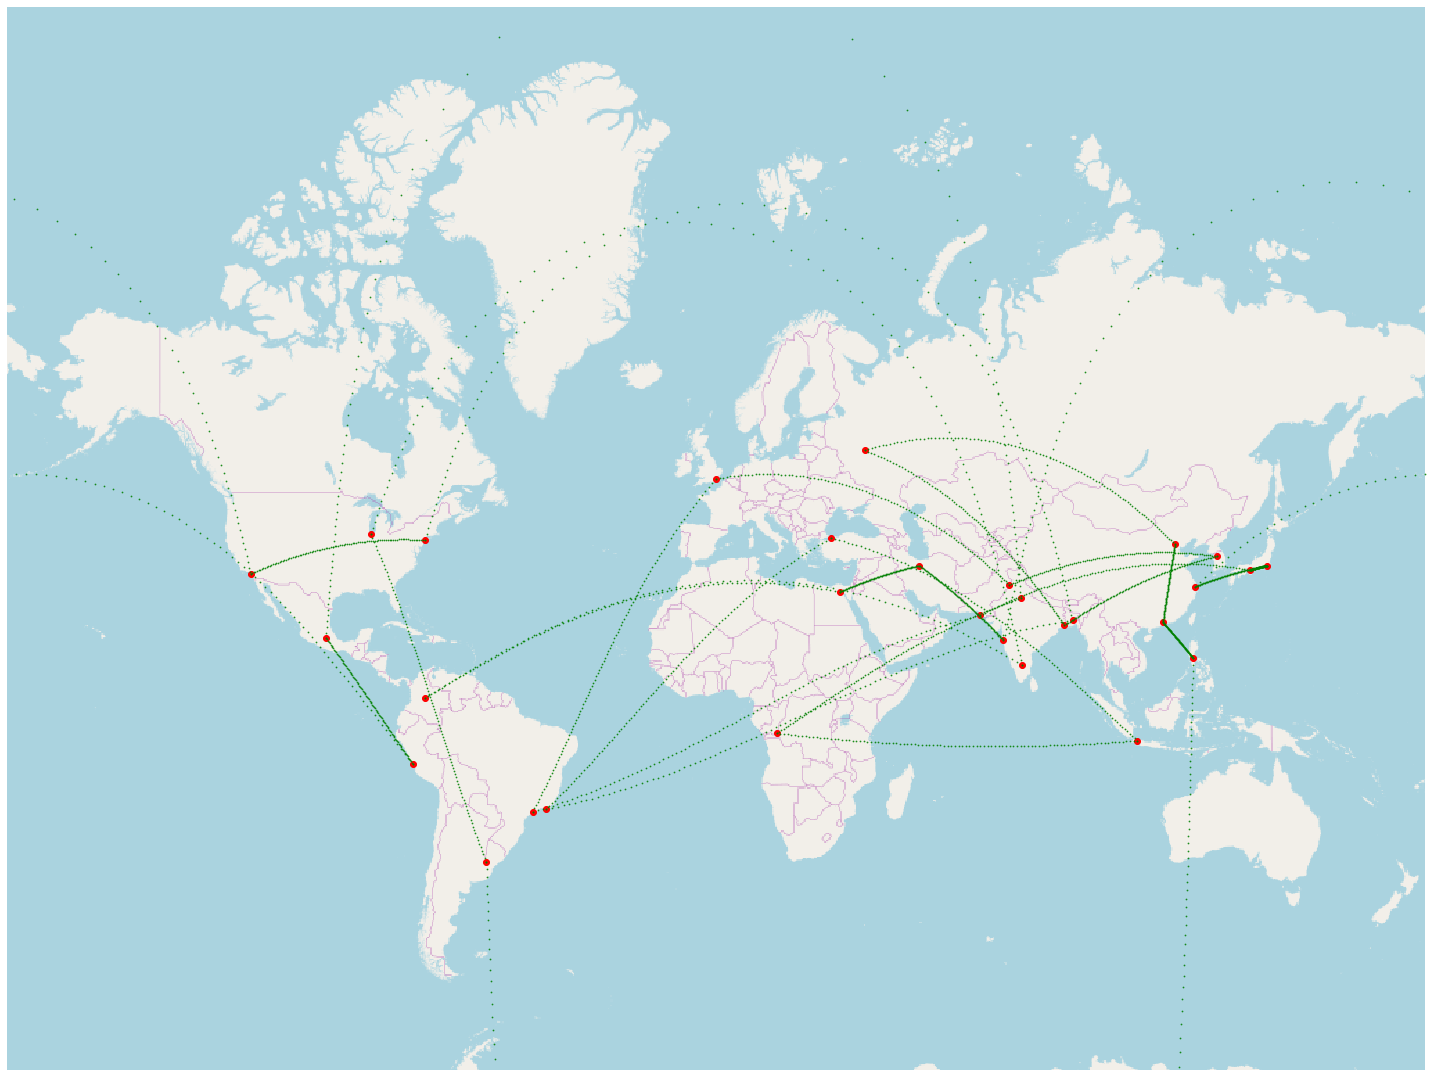

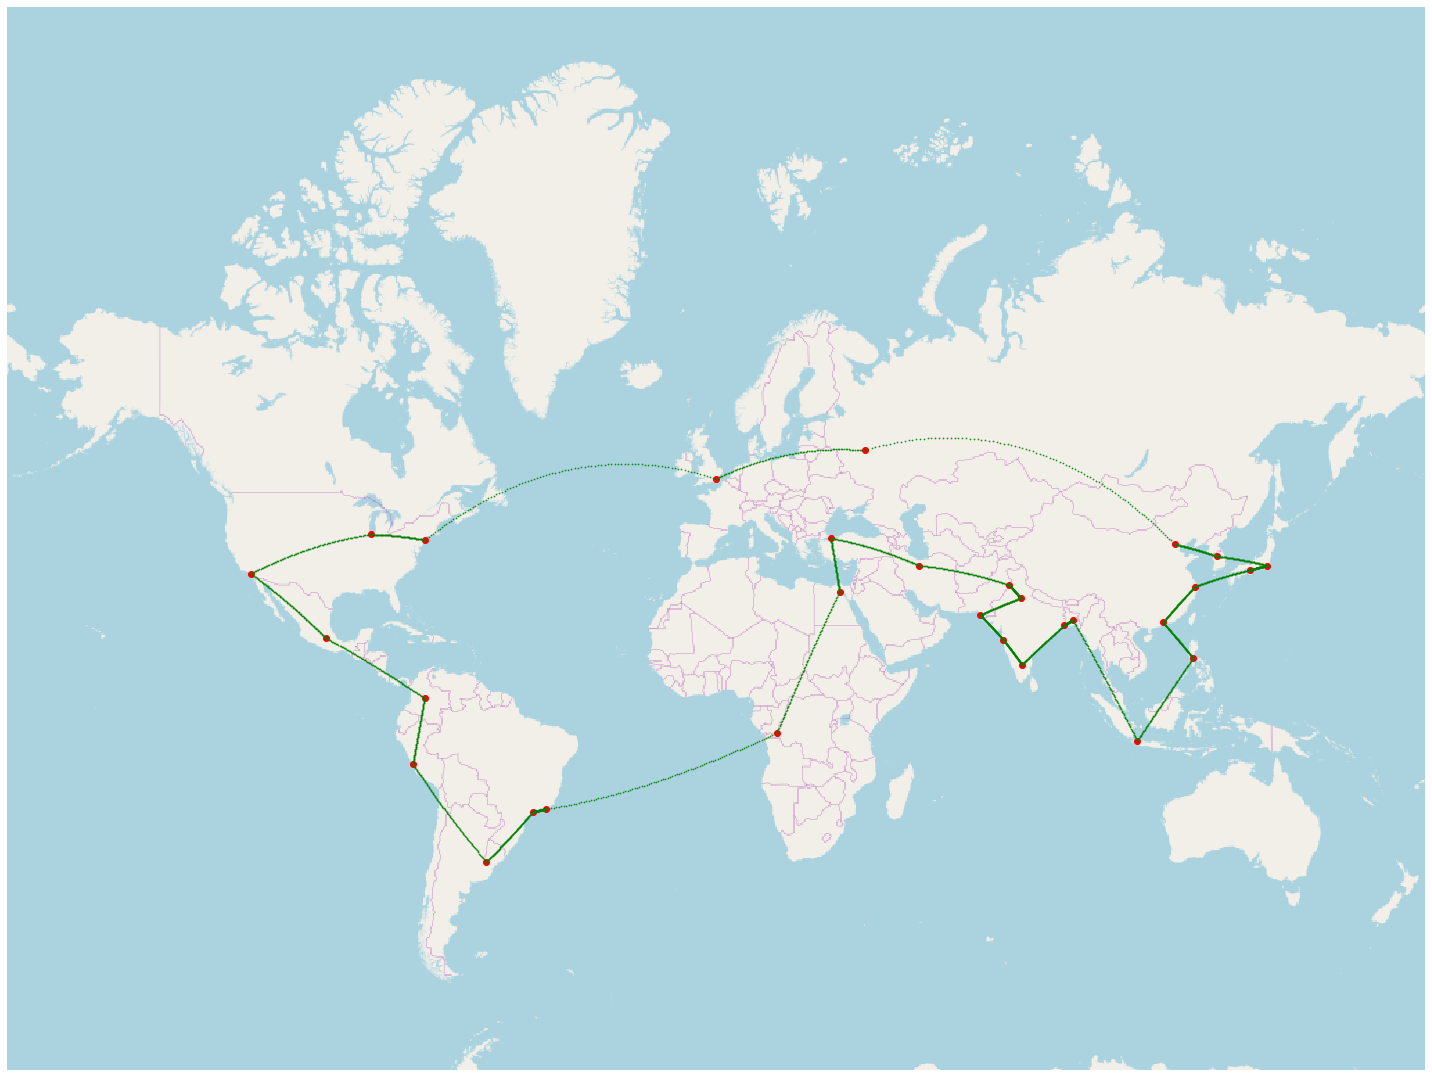

In [107]:
maxt=SalesmanAnneal(lats=tlats, lons=tlons, cities=tcits, basemap=worldmap, stopping_itt=8000,T=T,alpha=.95)
maxt.anneal()
maxt.print_grid(maxt.initial_route)
maxt.print_grid(maxt.bestroute)

Text(0, 0.5, 'Path Lenght')

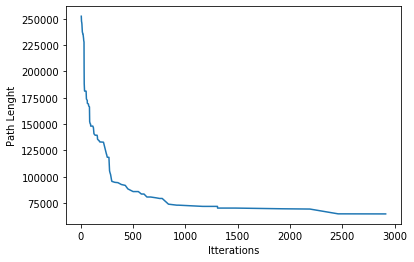

In [108]:
plt.plot(maxt.itterlist,maxt.lenght1)
plt.xlabel('Itterations')
plt.ylabel('Path Lenght')

In [109]:
print('Initial temp=',T,'\nFinal temp=',maxt.T*maxt.itterlist[-1])


Initial temp= 10000000000.0 
Final temp= 1.886289090288255e-165
